In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from math import sqrt
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

import env
import zillow_wrangle
import split_scale
import evaluate
import explore
import feature

# Data Science Pipeline

### Acquire
*Goal: Having a clean dataframe ready to prepare*

The ad hoc part includes summarizing your data as you read it in and begin to explore, look at the first few rows, data types, summary stats, column names, shape of the data frame, etc.

Brainstorming ideas, hypotheses, related to how variables might impact or relate to each other, both within independent variables and between the independent variables and dependent variable, and also related to any ideas for new features you may have while first looking at the existing variables and challenge ahead of you.

Have a detailed README.md file for anyone who wants to check out your project. In this file should be a description of what the project is, and any instructions necessary for someone else to clone your project and run the code on their own laptop.

During project planning, think about what things in your project are nice to have, versus which things are need to have. For example, you might document that you will only worry about trying to scale your features after creating and evaluating a baseline model.

#### - I'm acquiring my data using wrangle_zillow

In [2]:
df = zillow_wrangle.wrangle_zillow()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14968 entries, 0 to 14989
Data columns (total 16 columns):
id                              14968 non-null int64
bathroomcnt                     14968 non-null float64
bedroomcnt                      14968 non-null float64
calculatedfinishedsquarefeet    14968 non-null float64
fips                            14968 non-null float64
rawcensustractandblock          14968 non-null float64
regionidcounty                  14968 non-null float64
roomcnt                         14968 non-null float64
structuretaxvaluedollarcnt      14968 non-null float64
taxvaluedollarcnt               14968 non-null float64
assessmentyear                  14968 non-null float64
landtaxvaluedollarcnt           14968 non-null float64
taxamount                       14968 non-null float64
id                              14968 non-null int64
logerror                        14968 non-null float64
transactiondate                 14968 non-null object
dtypes: float64(

### Hypothesis:
- $H_0$: Number of bathrooms and bedrooms in home, as well as square footage will not be leading factors in predicting property value
- $H_a$: Number of bathrooms, bedrooms and square footage will have a strong reciprocy for predicting property value.
- $H_a$: Using recursive feature elimination from SK.learn will proove a different variation of features that will predict features mentioned above but not discluding other possible features included in the dataset

### Prep
*Goal: leave this section with a dataset that is split into train and test ready to be analyzed. Data types are appropriate, missing values have been addressed, as have any data integrity issues.*

##### After a bit of exploring, I noticed that every fip code was for a county in california , added that as the state

In [4]:
state = 'California'
df['State'] = state
df.head()

,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,rawcensustractandblock,regionidcounty,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,id,logerror,transactiondate,State
0,2061546,2.0,3.0,1458.0,6037.0,6.037901e+07,3101.0,0.0,108890.0,136104.0,2016.0,27214.0,2319.90,1248,-0.362001,2017-06-23,California
1,1834372,1.0,2.0,1421.0,6037.0,6.037232e+07,3101.0,0.0,11982.0,35606.0,2016.0,23624.0,543.69,1772,-0.146056,2017-06-30,California
2,1923117,3.0,4.0,2541.0,6059.0,6.059064e+07,1286.0,0.0,434887.0,880456.0,2016.0,445569.0,9819.72,2028,0.021085,2017-06-01,California
3,2121349,2.0,3.0,1650.0,6037.0,6.037703e+07,3101.0,0.0,165000.0,614000.0,2016.0,449000.0,7673.19,3273,-0.325393,2017-06-01,California
4,2093710,1.0,2.0,693.0,6037.0,6.037185e+07,3101.0,0.0,82416.0,274237.0,2016.0,191821.0,3267.47,3429,-0.005566,2017-06-29,California


#### There are only 3 unique fips numbers, so I added these to a seperate column called 'county'.

In [5]:
df.fips.unique()

array([6037., 6059., 6111.])

#### small for loop to convert fips to counties

In [6]:
county = []

for row in df['fips']:
    if row == 6037:
        county.append('Los Angelas')
    elif row == 6059:
        county.append('Orange')
    elif row == 6111:
        county.append('Ventura')
        
df['county'] = county        

In [7]:
df.groupby('county').count()

,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,rawcensustractandblock,regionidcounty,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,id,logerror,transactiondate,State
county,,,,,,,,,,,,,,,,,
Los Angelas,9586,9586,9586,9586,9586,9586,9586,9586,9586,9586,9586,9586,9586,9586,9586,9586,9586
Orange,4092,4092,4092,4092,4092,4092,4092,4092,4092,4092,4092,4092,4092,4092,4092,4092,4092
Ventura,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290


#### Creating a new column called tax_rate which is the amount taxed divided by the home value to give us the percentage taxed.

In [8]:
df['tax_rate'] = df.taxamount / df.taxvaluedollarcnt

df['tax_rate'] = df.tax_rate.round(3)

### plotting the tax distribution

In [9]:
df.head()

,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,rawcensustractandblock,regionidcounty,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,id,logerror,transactiondate,State,county,tax_rate
0,2061546,2.0,3.0,1458.0,6037.0,6.037901e+07,3101.0,0.0,108890.0,136104.0,2016.0,27214.0,2319.90,1248,-0.362001,2017-06-23,California,Los Angelas,0.017
1,1834372,1.0,2.0,1421.0,6037.0,6.037232e+07,3101.0,0.0,11982.0,35606.0,2016.0,23624.0,543.69,1772,-0.146056,2017-06-30,California,Los Angelas,0.015
2,1923117,3.0,4.0,2541.0,6059.0,6.059064e+07,1286.0,0.0,434887.0,880456.0,2016.0,445569.0,9819.72,2028,0.021085,2017-06-01,California,Orange,0.011
3,2121349,2.0,3.0,1650.0,6037.0,6.037703e+07,3101.0,0.0,165000.0,614000.0,2016.0,449000.0,7673.19,3273,-0.325393,2017-06-01,California,Los Angelas,0.012
4,2093710,1.0,2.0,693.0,6037.0,6.037185e+07,3101.0,0.0,82416.0,274237.0,2016.0,191821.0,3267.47,3429,-0.005566,2017-06-29,California,Los Angelas,0.012


In [10]:
county_df = df[['county', 'tax_rate']]
county_df.head()

,county,tax_rate
0,Los Angelas,0.017
1,Los Angelas,0.015
2,Orange,0.011
3,Los Angelas,0.012
4,Los Angelas,0.012


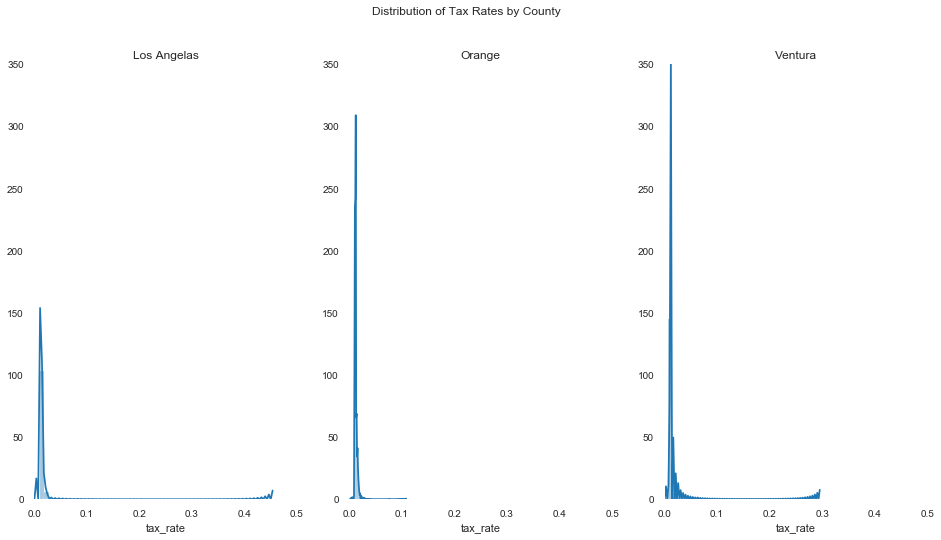

In [11]:
la = county_df[county_df.county == 'Los Angelas'].tax_rate
orange = county_df[county_df.county == 'Orange'].tax_rate
ventura = county_df[county_df.county == 'Ventura'].tax_rate

plt.figure(figsize=(16, 8))
plt.suptitle('Distribution of Tax Rates by County')

plt.subplot(131)
sns.distplot(la)
plt.title('Los Angelas')
plt.xlim(0, 0.5)
plt.ylim(0, 350)

plt.subplot(132)
sns.distplot(orange)
plt.title("Orange")
plt.xlim(0, 0.5)
plt.ylim(0, 350)

plt.subplot(133)
sns.distplot(ventura)
plt.title("Ventura")
plt.xlim(0, 0.5)
plt.ylim(0, 350)


plt.show()

## There are some crazy outliers in the Los Angelas and Ventura counties. I will show the distribution by cutting those outliers from the data, as they are heavily influencing the shape of the distribution.

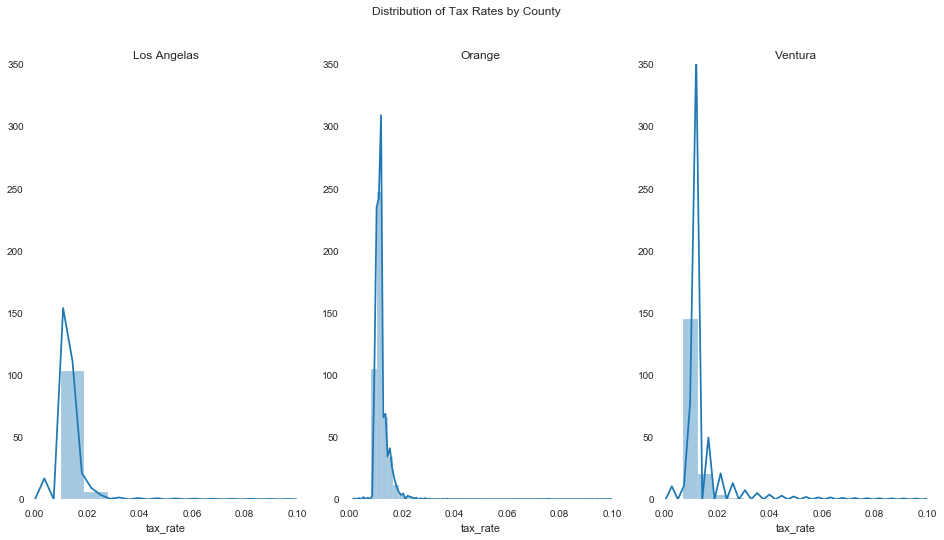

In [12]:
la = county_df[county_df.county == 'Los Angelas'].tax_rate
orange = county_df[county_df.county == 'Orange'].tax_rate
ventura = county_df[county_df.county == 'Ventura'].tax_rate

plt.figure(figsize=(16, 8))
plt.suptitle('Distribution of Tax Rates by County')

plt.subplot(131)
sns.distplot(la)
plt.title('Los Angelas')
plt.xlim(0, 0.1)
plt.ylim(0, 350)

plt.subplot(132)
sns.distplot(orange)
plt.title("Orange")
plt.xlim(0, 0.1)
plt.ylim(0, 350)

plt.subplot(133)
sns.distplot(ventura)
plt.title("Ventura")
plt.xlim(0, 0.1)
plt.ylim(0, 350)


plt.show()

The ad hoc part includes plotting the distributions of individual variables and using those plots to identify outliers and if those should be handled (and if so, how), identify unit scales to identify how to best scale the numeric data, as well as finding erroneous or invalid data that may exist in your dataframe.

### visualizing Data for pre-exploration

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14968 entries, 0 to 14989
Data columns (total 19 columns):
id                              14968 non-null int64
bathroomcnt                     14968 non-null float64
bedroomcnt                      14968 non-null float64
calculatedfinishedsquarefeet    14968 non-null float64
fips                            14968 non-null float64
rawcensustractandblock          14968 non-null float64
regionidcounty                  14968 non-null float64
roomcnt                         14968 non-null float64
structuretaxvaluedollarcnt      14968 non-null float64
taxvaluedollarcnt               14968 non-null float64
assessmentyear                  14968 non-null float64
landtaxvaluedollarcnt           14968 non-null float64
taxamount                       14968 non-null float64
id                              14968 non-null int64
logerror                        14968 non-null float64
transactiondate                 14968 non-null object
State           

### a lot of these parameters aren't viable features for our model, so I wittled it down to 4 possible features and our target variable

In [14]:
bed_bath_and_beyond = df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'roomcnt','taxvaluedollarcnt']]

In [15]:
bed_bath_and_beyond.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14968 entries, 0 to 14989
Data columns (total 5 columns):
bathroomcnt                     14968 non-null float64
bedroomcnt                      14968 non-null float64
calculatedfinishedsquarefeet    14968 non-null float64
roomcnt                         14968 non-null float64
taxvaluedollarcnt               14968 non-null float64
dtypes: float64(5)
memory usage: 701.6 KB


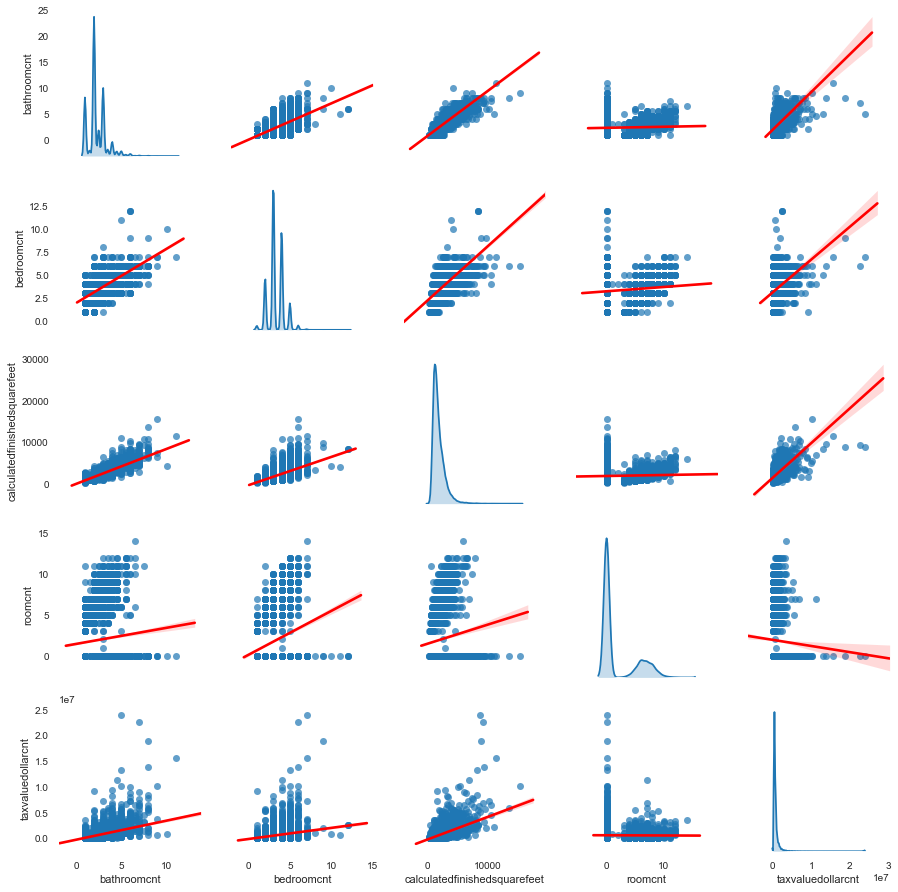

In [16]:
explore.plot_variable_pairs(bed_bath_and_beyond)

Add a data dictionary in your notebook that defines all fields used in your model and your analysis, and answers the question: why did you use the fields you used, e.g. why did you use bedroom_field1 over bedroom_field2, not why did you use number of bedrooms!

#### splitting our data

In [17]:
train, test = split_scale.split_my_data(df)

### Data Exploration
Goal: Address each of the questions you posed in your planning and brainstorming and any others you have come up with along the way through visual or statistical analysis.

When you have completed this step, you will have the findings from your analysis that will be used in your final report, answers to specific questions your customers has asked, and information to move forward toward building a model.

Run at least 1 t-test and 1 correlation test (but as many as you need!)
Visualize all combinations of variables in some way(s).
What independent variables are correlated with the dependent?
Which independent variables are correlated with other independent variables?
Make sure to summarize your takeaways and conclusions. That is, the data science zillow team doesn't want to see just a bunch of dataframes/numbers/charts without any explanation, you should explain in the notebook what these dataframes/numbers/charts mean.

### using ***pearson's r*** to test correlation

#### testing for bathroom count & property value

In [18]:
x = df.bathroomcnt
y = df.taxvaluedollarcnt 

corr, p = stats.pearsonr(x, y)
corr, p

(0.5193695839541569, 0.0)

#### Here we visualize our findings

In [19]:
#plt.bar(x, y)
#plt.show()

#### testing for correlation between bedroom count and property value

In [20]:
x = df.bedroomcnt

corr, p = stats.pearsonr(x, y)
corr, p

(0.27754229439220124, 7.419427448154762e-263)

#### Visuals for our correlation

In [21]:
#plt.bar(x, y)
#plt.show()

#### testing for correlation between square footage and property value

In [22]:
x = df.calculatedfinishedsquarefeet

corr, p = stats.pearsonr(x, y)
corr, p

(0.6048470394854684, 0.0)

#### visuals

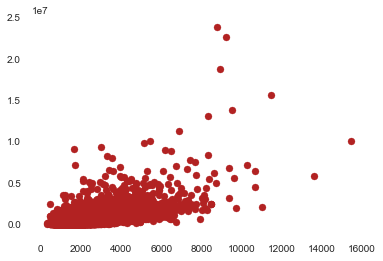

In [23]:
plt.scatter(x, y, c='firebrick')
plt.show()

#### testing correlation between room count and property value

In [24]:
x = df.roomcnt

corr, p = stats.pearsonr(x, y)
corr, p

(-0.01726232099319331, 0.03469343735569052)

#### visuals

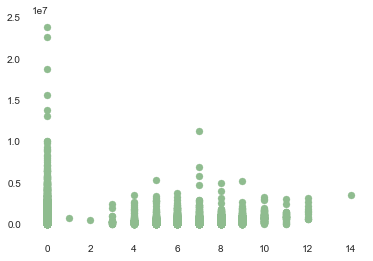

In [25]:
plt.scatter(x, y, c="darkseagreen")
plt.show()

### Modeling
Goal: develop a regression model that performs better than a baseline.

In [26]:
train = train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'roomcnt','taxvaluedollarcnt']]
test = test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'roomcnt','taxvaluedollarcnt']]

In [27]:
train.taxvaluedollarcnt.sort_values(ascending=False)

9547     22589311.0
5781     18812604.0
3853     15623925.0
1164     13852918.0
8110     13128583.0
            ...    
8755        16084.0
11280       15692.0
2822        14439.0
9853        11683.0
5783        10504.0
Name: taxvaluedollarcnt, Length: 11974, dtype: float64

In [28]:
X_train = train.drop(columns=['taxvaluedollarcnt'])
y_train = train[['taxvaluedollarcnt']]
X_test = test.drop(columns=['taxvaluedollarcnt'])
y_test = test[['taxvaluedollarcnt']]

#### developing baseline model

In [29]:
predictions = pd.DataFrame()

predictions['actual'] = y_train['taxvaluedollarcnt']
predictions['baseline'] = y_train['taxvaluedollarcnt'].mean()

In [30]:
predictions.head()

,actual,baseline
11609,900000.0,541494.694588
2291,680217.0,541494.694588
5182,558387.0,541494.694588
7834,207978.0,541494.694588
4836,761437.0,541494.694588


#### Evaluate baseline model,

In [31]:
evaluate.baseline_mean_errors(predictions.actual)

{'sse': 6235605807262970.0,
 'mse': 520762135231.5826,
 'rmse': 721638.5073092916}

##### These numbers are terrible...

### model # 1

### Now we're going to do a linear regression model using Recursive Feature Elimination from Scikit learn

- feature elimination

In [32]:
X_train.info(), y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11974 entries, 11609 to 11355
Data columns (total 4 columns):
bathroomcnt                     11974 non-null float64
bedroomcnt                      11974 non-null float64
calculatedfinishedsquarefeet    11974 non-null float64
roomcnt                         11974 non-null float64
dtypes: float64(4)
memory usage: 467.7 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11974 entries, 11609 to 11355
Data columns (total 1 columns):
taxvaluedollarcnt    11974 non-null float64
dtypes: float64(1)
memory usage: 187.1 KB


(None, None)

In [33]:
# Initialize the Linear Regression Object 
lm = LinearRegression()
rfe = RFE(lm, 3)

# Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

#### we have our 3 features from sklearn

In [34]:
#boolean mask for each variable of whether it was selected or not. 
mask = rfe.support_

# select the column names of the features that were selected and convert them to a list for future use. 
rfe_features = X_train.columns[mask]

# print them out here for our reference
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

selected 3 features: bathroomcnt, bedroomcnt, roomcnt


In [35]:
# Fitting the data to model
lm.fit(X_rfe, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("features: ", rfe_features)
print("coefficients: ", lm.coef_)

Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [-180090.38480542]
features:  Index(['bathroomcnt', 'bedroomcnt', 'roomcnt'], dtype='object')
coefficients:  [[424351.8255184  -75136.26162468  -9322.67717045]]


In [37]:
predictions['model1'] = lm.predict(X_rfe)

In [38]:
predictions.head()

,actual,baseline,model1
11609,900000.0,541494.694588,9.398892e+04
2291,680217.0,541494.694588,1.490851e+06
5182,558387.0,541494.694588,4.432045e+05
7834,207978.0,541494.694588,4.432045e+05
4836,761437.0,541494.694588,5.183407e+05


#### now we're grabbing our regression errors

In [39]:
evaluate.regression_errors(predictions.actual, predictions.model1)

,metric,model_values
0,SSE,4.395710e+15
1,ESS,1.839896e+15
2,TSS,6.235606e+15
3,MSE,3.671045e+11
4,RMSE,6.058915e+05
5,R^2,2.950629e-01


In [113]:
print(f"Our R^2: ", 2.950629** -1, "RMSE: ", 6.058915 ** 5)

Our R^2:  0.3389107881743181 RMSE:  8165.34049029063


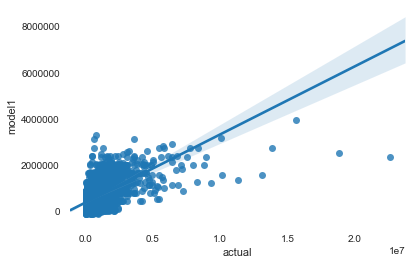

In [41]:
sns.regplot(predictions.actual, predictions.model1)

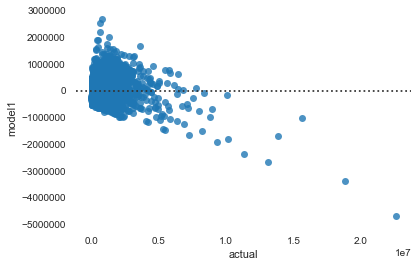

In [42]:
evaluate.plot_residuals(predictions, predictions.actual, predictions.model1)

### Ran on our test, data

In [43]:
model_predictions = pd.DataFrame()

model_predictions['actual'] = y_test['taxvaluedollarcnt']

model1 = lm.predict(test[['bathroomcnt', 'bedroomcnt', 'roomcnt']])

model_predictions['model1'] = model1

#### evaluating our test data with the regression errors and plotting our residuals

In [44]:
evaluate.regression_errors(model_predictions.actual, model_predictions.model1)

,metric,model_values
0,SSE,1.354413e+15
1,ESS,4.453315e+14
2,TSS,1.714378e+15
3,MSE,4.523756e+11
4,RMSE,6.725888e+05
5,R^2,2.597628e-01


In [114]:
print("R^2:", 2.597628**-1, "RMSE: ", 6.725888**5 )

R^2: 0.38496659259909427 RMSE:  13764.110662796473


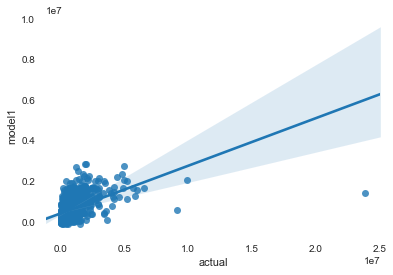

In [46]:
sns.regplot(model_predictions.actual, model_predictions.model1)

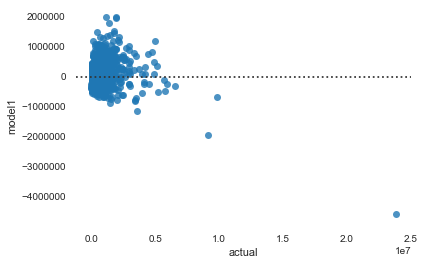

In [47]:
evaluate.plot_residuals(model_predictions, model_predictions.actual, model_predictions.model1)

### Model 2 we will do a linear regression model after selecting features from SelectKBest

In [48]:
# We are initializing ourf_selector object
f_selector = SelectKBest(f_regression, k=2)

# fitting the object to our data 
f_selector.fit(X_train, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x12f8179e0>)

In [49]:
# transforming our dataset to reduce kbest features
X_reduced = f_selector.transform(X_train)

f_support = f_selector.get_support()

f_feature = X_train.loc[:,f_support].columns.tolist()

print(str(len(f_feature)), 'selected features')
print(f_feature)

2 selected features
['bathroomcnt', 'calculatedfinishedsquarefeet']


In [50]:
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [51]:
# Fitting the data to model
K_best_train = X_train[['bathroomcnt', 'calculatedfinishedsquarefeet']]
lm.fit(K_best_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [52]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("features: ", f_feature)
print("coefficients: ", lm.coef_)

Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [-327479.44942744]
features:  ['bathroomcnt', 'calculatedfinishedsquarefeet']
coefficients:  [[10967.62834774   433.73308985]]


In [53]:
predictions['model2'] = lm.predict(K_best_train)

In [54]:
predictions.head()

,actual,baseline,model1,model2
11609,900000.0,541494.694588,9.398892e+04,-8.127594e+03
2291,680217.0,541494.694588,1.490851e+06,1.340846e+06
5182,558387.0,541494.694588,4.432045e+05,6.443313e+05
7834,207978.0,541494.694588,4.432045e+05,1.524780e+05
4836,761437.0,541494.694588,5.183407e+05,1.923814e+05


In [55]:
evaluate.regression_errors(predictions.actual, predictions.model2)

,metric,model_values
0,SSE,3.847969e+15
1,ESS,2.387637e+15
2,TSS,6.235606e+15
3,MSE,3.213603e+11
4,RMSE,5.668865e+05
5,R^2,3.829038e-01


In [115]:
print("R^2: ", 3.829038**-1, "RMSE: ", 5.668865**5)

R^2:  0.26116220314345273 RMSE:  5854.375484220518


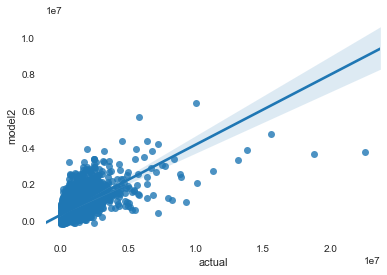

In [57]:
sns.regplot(predictions.actual, predictions.model2)

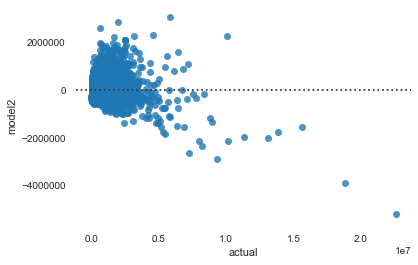

In [58]:
evaluate.plot_residuals(predictions, predictions.actual, predictions.model2)

### Ran on our test data

In [59]:
model2 = lm.predict(test[['bathroomcnt', 'calculatedfinishedsquarefeet']])

model_predictions['model2'] = model2

#### evaluating our regression errors & plotting our residuals

In [60]:
evaluate.regression_errors(model_predictions.actual, model_predictions.model2)

,metric,model_values
0,SSE,1.193801e+15
1,ESS,5.595495e+14
2,TSS,1.714378e+15
3,MSE,3.987311e+11
4,RMSE,6.314516e+05
5,R^2,3.263864e-01


In [116]:
print("R^2: ", 3.263864**-1, "RMSE: ", 6.314516**5  )

R^2:  0.30638531507440264 RMSE:  10039.228521022162


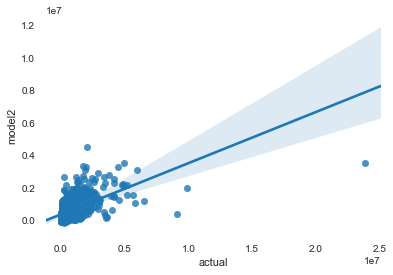

In [62]:
sns.regplot(model_predictions.actual, model_predictions.model2)

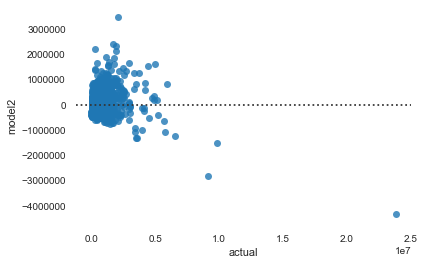

In [63]:
evaluate.plot_residuals(model_predictions, model_predictions.actual, model_predictions.model2)

### model 3 we will be using number of bedrooms, bathrooms and square footage to predict property value

In [64]:
X_train = X_train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]

In [65]:
# initializing linear regression model from sklearn
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [66]:
# Fitting the data to model
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [67]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("features: ", X_train.columns)
print("coefficients: ", lm.coef_)

Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [-33944.53327921]
features:  Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet'], dtype='object')
coefficients:  [[  65620.65329726 -152460.02648243     477.43602453]]


In [68]:
predictions['model3'] = lm.predict(X_train)

predictions.head()

,actual,baseline,model1,model2,model3
11609,900000.0,541494.694588,9.398892e+04,-8.127594e+03,6.621308e+04
2291,680217.0,541494.694588,1.490851e+06,1.340846e+06,1.155461e+06
5182,558387.0,541494.694588,4.432045e+05,6.443313e+05,6.855016e+05
7834,207978.0,541494.694588,4.432045e+05,1.524780e+05,1.440891e+05
4836,761437.0,541494.694588,5.183407e+05,1.923814e+05,3.404733e+05


#### grab those regression errors

In [69]:
evaluate.regression_errors(predictions.actual, predictions.model3)

,metric,model_values
0,SSE,3.710553e+15
1,ESS,2.525053e+15
2,TSS,6.235606e+15
3,MSE,3.098842e+11
4,RMSE,5.566724e+05
5,R^2,4.049410e-01


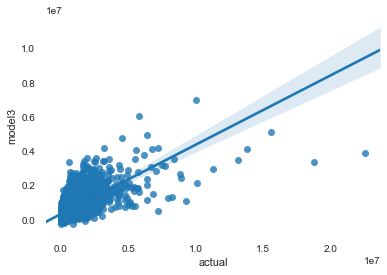

In [70]:
sns.regplot(predictions.actual, predictions.model3)

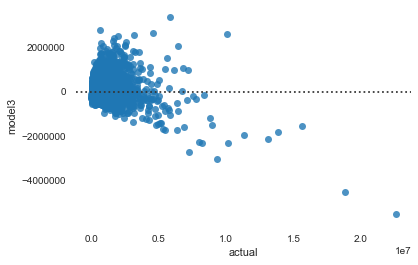

In [71]:
evaluate.plot_residuals(predictions, predictions.actual, predictions.model3)

In [72]:
print(f"R^2: ", 3.903000**-1, "RMSE: ", 5.208625 ** 5 )

R^2:  0.25621316935690497 RMSE:  3833.676436807745


### running our model on our test data

In [73]:
model3 = lm.predict(test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']])

model_predictions['model3'] = model3

#### grabbing our regression errors and plotting our residuals

In [74]:
evaluate.regression_errors(model_predictions.actual, model_predictions.model3)

,metric,model_values
0,SSE,1.168335e+15
1,ESS,6.031389e+14
2,TSS,1.714378e+15
3,MSE,3.902253e+11
4,RMSE,6.246802e+05
5,R^2,3.518122e-01


In [75]:
print("R^2: ", 5.284769**-1, "RMSE: ", 4.317318**5)

R^2:  0.189223029426641 RMSE:  1499.9272420732107


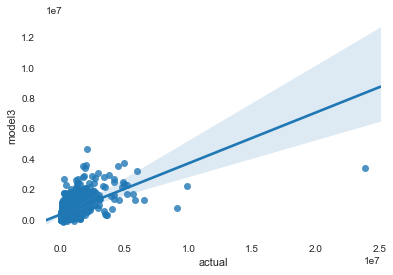

In [76]:
sns.regplot(model_predictions.actual, model_predictions.model3)

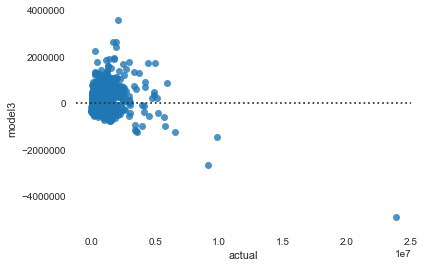

In [77]:
evaluate.plot_residuals(model_predictions, model_predictions.actual, model_predictions.model3)

### Going back to the tax distribution idea, maybe it would be a more accurate model if we split our data by county and modeled our data by county

#### I'm going to take my most accurate model, and use it on this data split by county

In [78]:
la = df[df.county == 'Los Angelas']
orange = df[df.county == 'Orange']
ventura = df[df.county == 'Ventura']

### train test data

In [79]:
la_train, la_test = split_scale.split_my_data(la)
orange_train, orange_test = split_scale.split_my_data(orange)
ventura_train, ventura_test = split_scale.split_my_data(ventura)

In [80]:
county_predictions = pd.DataFrame()
county_predictions['actual'] = la_train.taxvaluedollarcnt

### Los angelas

In [81]:
X_train = la_train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_train = la_train.taxvaluedollarcnt

# initializing linear regression model from sklearn
lm = LinearRegression()
lm

# Fitting the data to model
lm.fit(X_train, y_train)


county_predictions['LA'] = lm.predict(X_train)

county_predictions.head()

,actual,LA
1520,402000.0,97388.257483
7315,640000.0,463290.800942
12370,213202.0,519141.740495
7936,318210.0,555769.942564
9212,1346193.0,607700.903346


In [82]:
evaluate.regression_errors(county_predictions.actual, county_predictions.LA)

,metric,model_values
0,SSE,2.713513e+15
1,ESS,1.747338e+15
2,TSS,4.460851e+15
3,MSE,3.538750e+11
4,RMSE,5.948739e+05
5,R^2,3.917050e-01


In [83]:
print("R^2: ",3.885693**-1, "RMSE: ",  5.900845**5)

R^2:  0.2573543509484666 RMSE:  7154.364041689948


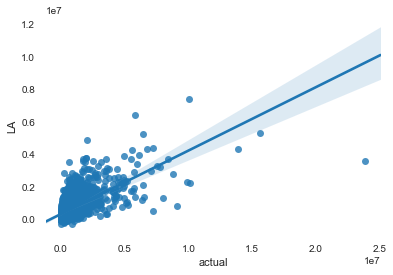

In [84]:
sns.regplot(county_predictions.actual, county_predictions.LA)

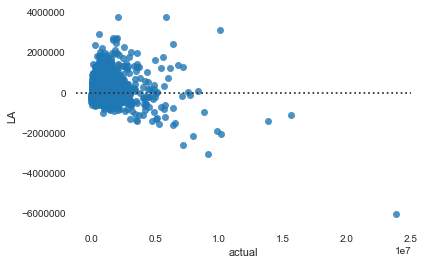

In [85]:
evaluate.plot_residuals(county_predictions, county_predictions.actual, county_predictions.LA)

### Los Angelas test data

In [86]:
test_results = pd.DataFrame()
test_results['actual'] = la_test.taxvaluedollarcnt

In [87]:
Los_angelas = lm.predict(la_test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']])

test_results['LA'] = Los_angelas


evaluate.regression_errors(test_results.actual, test_results.LA)

,metric,model_values
0,SSE,1.154045e+15
1,ESS,4.115858e+14
2,TSS,1.775214e+15
3,MSE,6.016916e+11
4,RMSE,7.756878e+05
5,R^2,2.318513e-01


In [117]:
print("R2: ", 2.318513**-1, "RMSE: ", 7.756878**5 )

R2:  0.43131093075604926 RMSE:  28082.43773444291


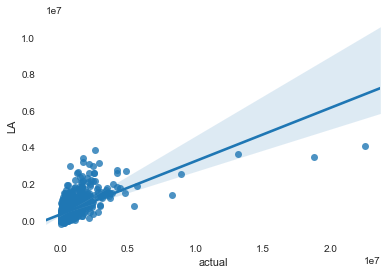

In [89]:
sns.regplot(test_results.actual, test_results.LA)

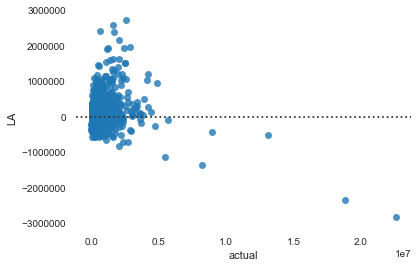

In [90]:
evaluate.plot_residuals(test_results, test_results.actual, test_results.LA)

### Orange County

In [91]:
county_predictions = pd.DataFrame()
county_predictions['actual'] = orange_train.taxvaluedollarcnt

In [92]:
X_train = orange_train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_train = orange_train.taxvaluedollarcnt

# initializing linear regression model from sklearn
lm = LinearRegression()
lm

# Fitting the data to model
lm.fit(X_train, y_train)


county_predictions['orange'] = lm.predict(X_train)

county_predictions.head()

,actual,orange
8497,467000.0,171414.081152
8611,342663.0,185818.481749
9869,313565.0,531023.162017
4289,499925.0,605215.733119
13194,404294.0,439914.019020


In [93]:
evaluate.regression_errors(county_predictions.actual, county_predictions.orange)

,metric,model_values
0,SSE,7.671634e+14
1,ESS,5.756973e+14
2,TSS,1.342861e+15
3,MSE,2.343915e+11
4,RMSE,4.841400e+05
5,R^2,4.287097e-01


In [118]:
print("R2: ", 4.287097**-1, "RMSE: ", 4.841400**5 )

R2:  0.23325807650258437 RMSE:  2659.83581317893


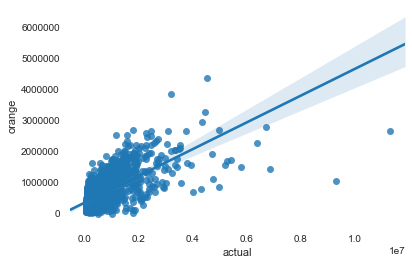

In [95]:
sns.regplot(county_predictions.actual, county_predictions.orange)

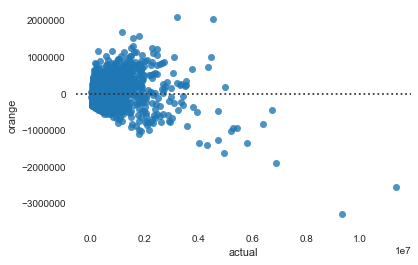

In [96]:
evaluate.plot_residuals(county_predictions, county_predictions.actual, county_predictions.orange)

#### orange Test data

In [97]:
test_results = pd.DataFrame()
test_results['actual'] = orange_test.taxvaluedollarcnt

In [98]:
orange = lm.predict(orange_test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']])

test_results['orange'] = orange


evaluate.regression_errors(test_results.actual, test_results.orange)

,metric,model_values
0,SSE,1.049128e+14
1,ESS,1.413303e+14
2,TSS,1.892780e+14
3,MSE,1.280986e+11
4,RMSE,3.579087e+05
5,R^2,7.466814e-01


In [119]:
print("R2: ", 7.466814**-1, "RMSE: ", 3.579087**5 )

R2:  0.1339259287830124 RMSE:  587.3017250459345


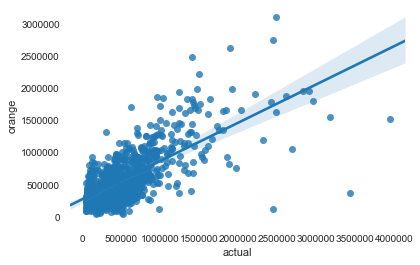

In [100]:
sns.regplot(test_results.actual, test_results.orange)

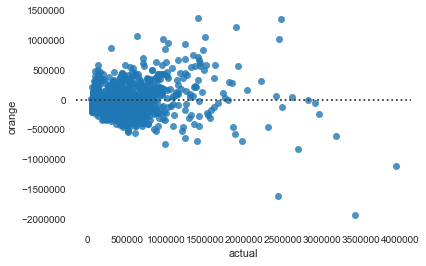

In [101]:
evaluate.plot_residuals(test_results, test_results.actual, test_results.orange)

### Ventura County

In [102]:
county_predictions = pd.DataFrame()
county_predictions['actual'] = ventura_train.taxvaluedollarcnt

In [103]:
X_train = ventura_train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_train = ventura_train.taxvaluedollarcnt

# initializing linear regression model from sklearn
lm = LinearRegression()
lm

# Fitting the data to model
lm.fit(X_train, y_train)


county_predictions['ventura'] = lm.predict(X_train)

county_predictions.head()

,actual,ventura
1537,652686.0,6.420084e+05
64,1389230.0,1.608832e+06
7762,339846.0,5.434051e+05
2603,57881.0,2.732798e+05
6252,442266.0,2.855219e+05


In [104]:
evaluate.regression_errors(county_predictions.actual, county_predictions.ventura)

,metric,model_values
0,SSE,4.747377e+13
1,ESS,6.385961e+13
2,TSS,1.113334e+14
3,MSE,4.600171e+10
4,RMSE,2.144801e+05
5,R^2,5.735891e-01


In [120]:
print("R2: ", 5.735891**-1, "RMSE: ", 2.144801**5 )

R2:  0.17434083039583564 RMSE:  45.38736992763405


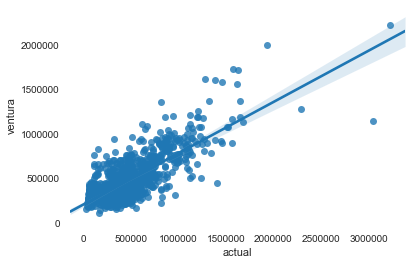

In [106]:
sns.regplot(county_predictions.actual, county_predictions.ventura)

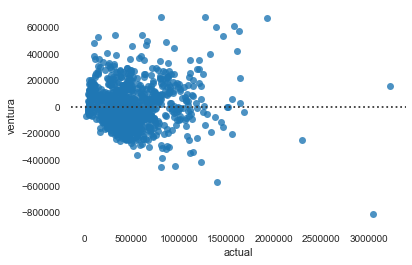

In [107]:
evaluate.plot_residuals(county_predictions, county_predictions.actual, county_predictions.ventura)

#### ventura test data

In [108]:
test_results = pd.DataFrame()
test_results['actual'] = ventura_test.taxvaluedollarcnt

In [109]:
ventura = lm.predict(ventura_test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']])

test_results['ventura'] = ventura

evaluate.regression_errors(test_results.actual, test_results.ventura)

,metric,model_values
0,SSE,1.308474e+13
1,ESS,1.780370e+13
2,TSS,3.553593e+13
3,MSE,5.071606e+10
4,RMSE,2.252023e+05
5,R^2,5.010055e-01


In [121]:
print("R2: ", 5.010055**-1, "RMSE: ", 2.252023**5 )

R2:  0.19959860720091893 RMSE:  57.9247420331724


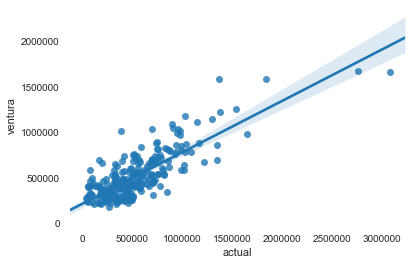

In [111]:
sns.regplot(test_results.actual, test_results.ventura)

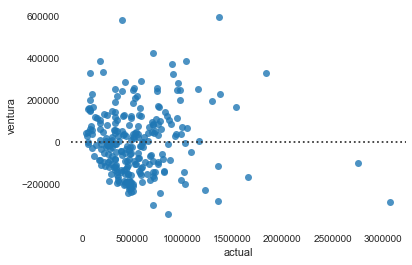

In [112]:
evaluate.plot_residuals(test_results, test_results.actual, test_results.ventura)

Your notebook will contain various algorithms and/or hyperparameters tried, along with the evaluation code and results, before settling on the final algorithm.

Be sure and evaluate your model using the standard techniques: plotting the residuals, computing the evaluation metric (SSE, RMSE, and/or MSE), comparing to baseline, plotting 
y
 by 
^
y
.

model.py: will have the functions to fit, predict and evaluate the final model on the test data set.